Imports

In [2]:
import random

import cv2
from matplotlib import pyplot as plt
import os
import xml.etree.ElementTree as ET

import albumentations as A

List files in directory

In [3]:
base_path = '../data/cropped/combine'

# list all files in directory
files = sorted(os.listdir(base_path))
n_files = len(files)
print("Nr of files: ", n_files)
# print("Files: ", files)

Nr of files:  1200


Helper functions

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

Load image

In [9]:
# files
idx = 200
files_xml = [f for f in files if f.endswith('.xml')]
files_img = [f for f in files if f.endswith('.png')]

# read img
img_path = os.path.join(base_path, files_img[idx])
print("img_path: ", img_path)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# read XML
xml_path = os.path.join(base_path, files_xml[idx])
xml_file_orig = ET.parse(xml_path)
root = xml_file_orig.getroot()   

img_path:  ../data/cropped/combine\mixed_raw_134.png


Define bounding boxes

In [10]:
bboxes = []

# loop over each bounding box
for obj in root.iter('bndbox'):
    xmin = obj.find('xmin')
    xmax = obj.find('xmax')
    ymin = obj.find('ymin')
    ymax = obj.find('ymax')  
    bboxes.append((int(xmin.text), int(ymin.text), int(xmax.text), int(ymax.text)))

print("bboxes: ", bboxes)    

category_ids = [5, 2]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {5: '5', 2: '2'}

bboxes:  [(159, 108, 292, 239), (366, 102, 478, 230)]


Visualize

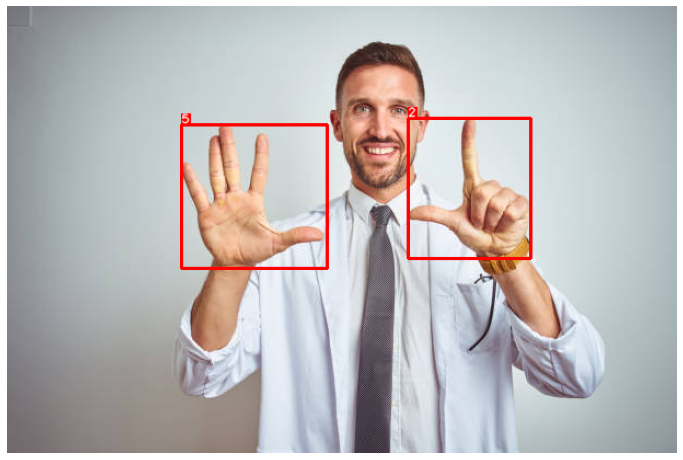

In [11]:
visualize(image, bboxes, category_ids, category_id_to_name)

Define transform

In [12]:
transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, scale_limit=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
        A.AdvancedBlur(p=0.5),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']),
)

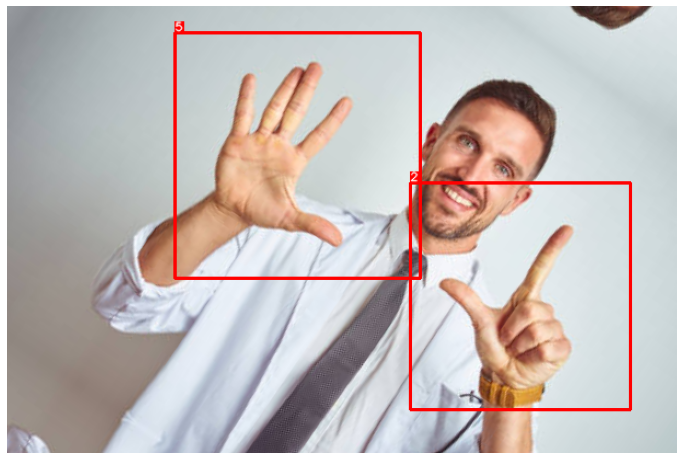

In [20]:
# random.seed(7)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

visualize(transformed['image'],
          transformed['bboxes'],
          transformed['category_ids'],
          category_id_to_name,)